# Elliptic Cryptocurrency Transaction Analysis - Adi Kondepudi
## 

https://www.kaggle.com/datasets/ellipticco/elliptic-data-set?resource=download

The elliptic data set maps bitcoin transfers between entities, both licit and illicit.

There are 203,769 nodes and 234,355 edges. Nodes are entities and edges are transactions.

Among the nodes, 2% (4545) are illicit and 21% (42019) are licit. The rest are unknown.

There are 166 features for each node.

The first feature is the time step for that node. Each time step represents a connected component of nodes with edges (transactions) that have all occured within three hours of each other.

The next 93 features give information about the transactions made by that node (fees, volume, averages, etc).

The last 72 features are aggregated from adjacent nodes.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import graspologic
import matplotlib.pyplot as plt

In [3]:
# reading data
df_features = pd.read_csv("./elliptic/elliptic_txs_features.csv", header=None)
df_classes= pd.read_csv("./elliptic/elliptic_txs_classes.csv")
df_edgelist = pd.read_csv("./elliptic/elliptic_txs_edgelist.csv")

# renaming columns
df_classes.loc[df_classes['class'] == '1', 'class'] = "illicit"
df_classes.loc[df_classes['class'] == '2', 'class'] = "licit"

df_features.columns = ["id", "time step"] + [f"local_feat_{i}" for i in range(93)] + [f"agg_feat_{i}" for i in range(72)]
df_classes.columns = ["id", "class"]

# adding class data
df = pd.merge(df_features, df_classes, how="inner", on="id")
second_column = df.pop('class')
df.insert(1, 'class', second_column)
df.head()

,id,class,time step,local_feat_0,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
0,230425980,unknown,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,unknown,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,unknown,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,licit,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,unknown,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [4]:
df2 = df.groupby(['time step'])['time step'].count().sort_values(ascending=False)
df2

time step
1     7880
42    7140
5     6803
10    6727
3     6621
36    6393
7     6048
22    5894
4     5693
45    5598
35    5507
41    5342
47    5121
43    5063
9     4996
44    4975
24    4592
2     4544
13    4528
32    4525
40    4481
8     4457
6     4328
11    4296
20    4291
29    4275
23    4165
15    3639
21    3537
46    3519
19    3506
17    3385
37    3306
33    3151
16    2975
48    2954
38    2891
31    2816
39    2760
26    2523
34    2486
30    2483
49    2454
25    2314
12    2047
14    2022
18    1976
28    1653
27    1089
Name: time step, dtype: int64

Accuracy on test data: 0.9827123375926125


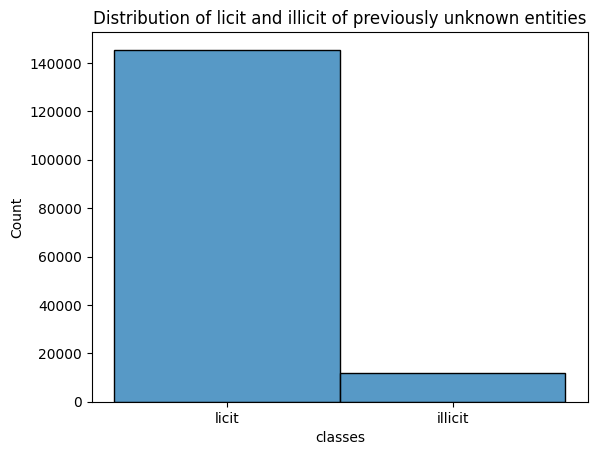

In [5]:
# Using PyTorch to use a neural network to classify the unknown values
import torch
from torch.utils.data import DataLoader, TensorDataset

# df with known valyes
df_licit_illicit = df[df["class"] != "unknown"]

y = df_licit_illicit.iloc[:, 0:2]
y = y.drop(["id"], axis=1).values
X = df_licit_illicit.drop(["class", "id", "time step"], axis=1).values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = y.ravel()
y = le.fit_transform(y)

X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).long()

# Create a TensorDataset to hold the data
data = TensorDataset(X_tensor, y_tensor)

# Split the data into training and test sets
train_data, test_data = torch.utils.data.random_split(data, [int(0.8 * len(data)), len(data) - int(0.8 * len(data))])

# Create data loaders for the training and test sets
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

# Define the neural network
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(in_features=X.shape[1], out_features=64)
        self.fc2 = torch.nn.Linear(in_features=64, out_features=64)
        self.fc3 = torch.nn.Linear(in_features=64, out_features=len(set(y)))

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the network
net = Net()

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Train the network
for epoch in range(10):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# # Test the network
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Accuracy on test data: {correct / total}')


# creating df of unknown values
df_unknown = df[df["class"] == "unknown"]
df_unknown = df_unknown.drop(['class', 'time step', "id"], axis=1)
df_unknown = df_unknown.values
df_unknown_tensor = torch.from_numpy(df_unknown).float()

# Use the neural network to classify the new data
with torch.no_grad():
    # Run the new data through the network
    output = net(df_unknown_tensor)
    # Get the predicted class for each sample
    _, predicted = torch.max(output.data, 1)

predicted = predicted.cpu()
predicted = le.inverse_transform(predicted)

df_df_unknown = df[df["class"] == "unknown"]
df_df_unknown = df_df_unknown.drop(['class', 'time step', "id"], axis=1)

df_df_unknown['classes'] = predicted.tolist()

data = df_df_unknown["classes"]
sns.histplot(data, bins=20)
plt.title("Distribution of licit and illicit of previously unknown entities")

plt.show()

In [6]:
# function to create a networkx graph for each time step
def plot(i):
    time_step_i = df.loc[(df['time step'] == i), 'id']
    time_step_i = df_edgelist.loc[df_edgelist['txId1'].isin(time_step_i)]
    g = nx.from_pandas_edgelist(time_step_i, source = 'txId1', target = 'txId2', create_using = nx.DiGraph())
    return g

from graspologic.utils import is_fully_connected

for i in range (1,50):
    time_step_i = df.loc[(df['time step'] == i), 'id']
    time_step_i = df_edgelist.loc[df_edgelist['txId1'].isin(time_step_i)]
    g = nx.from_pandas_edgelist(time_step_i, source = 'txId1', target = 'txId2', create_using = nx.DiGraph())
    if(is_fully_connected(g) == True):
        # print("Time Step ", i, "is strongly connected.")
        pass
    else:
        if(nx.is_weakly_connected(g) == True):
            print("Time Step ", i, "is weakly connected.")
        else:
            print("Time Step ", i, "isn't connected.")

# Because no statements were printed, all nodes in each time step are strongly connected.
# This what Elliptic says about the data, each component is completely connected. 

From this point forward, we'll be doing most of our measures on a time step 27. Not only will this increase our processing times, our measures will make more sense as all nodes within time step 27 are strongly connected. The reason why we chose time step 27 is because it is the time step with the least number of nodes. 

In [16]:
# Computing the eigenvector centrality

def map_to_nodes(node_map):
    node_map.setdefault(0)
    # utility function to make it easy to compare dicts to array outputs
    return np.array(np.vectorize(lambda x: node_map.setdefault(x, 0))(nodelist))

g = plot(27)
nodelist = list(g.nodes)
eg_centrality = map_to_nodes(dict(nx.eigenvector_centrality(g, max_iter=1000)))
eg_centrality.sort()

In [17]:
betweenness_centrality = map_to_nodes(nx.betweenness_centrality(g))
betweenness_centrality.sort()

(-4.017718803882599,
 15.178156149387359,
 -1.6427005350589754,
 15.672147494554519)

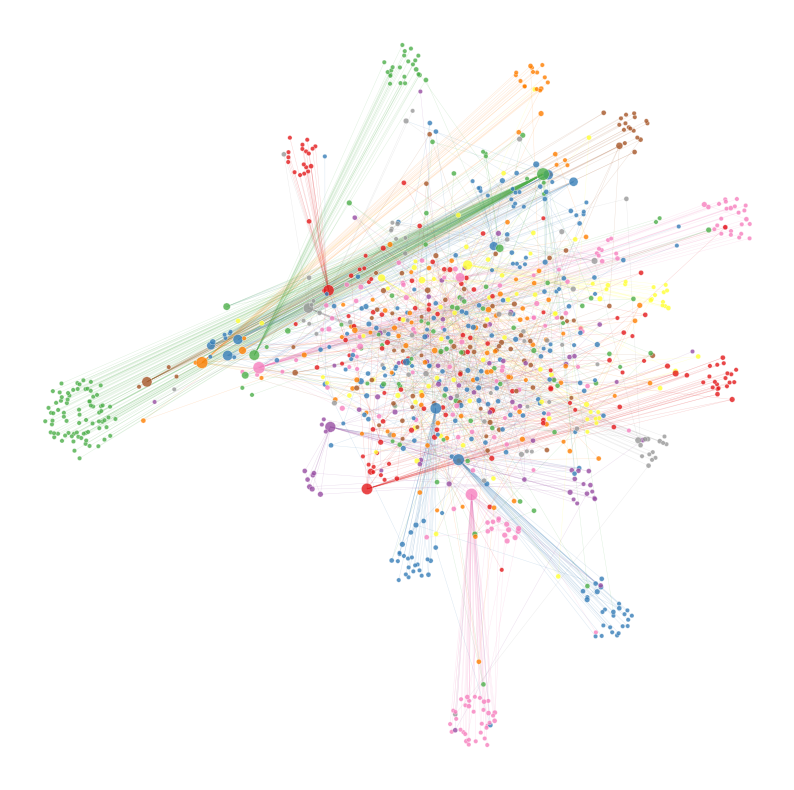

In [8]:
# plotting Time Step 27

import time
from pathlib import Path
import pandas as pd
import networkx as nx
import numpy as np
from scipy.sparse import csr_array
from graspologic.partition import leiden


g = plot(27)
nodelist = list(g.nodes)
adj = nx.to_scipy_sparse_array(g, nodelist=nodelist)

# the below function simply just converts a graph to be undirected.
# we can use the networkx function because our graph isn't weighted
def symmetrze_nx(g):
    """Leiden requires a symmetric/undirected graph. This converts a directed graph to
    undirected just for this community detection step"""
    sym_g = g.to_undirected()
    return sym_g

sym_g = symmetrze_nx(g)
out2 = leiden(sym_g)

node_df = pd.Series(out2)
node_df.index.name = "node_id"
node_df.name = "community"
node_df = node_df.to_frame()

nodelist = node_df.index
adj = nx.to_scipy_sparse_array(g, nodelist=nodelist)

node_df["strength"] = adj.sum(axis=1) + adj.sum(axis=0)
node_df['rank_strength'] = node_df['strength'].rank(method='dense')

from graspologic.embed import LaplacianSpectralEmbed
from graspologic.utils import pass_to_ranks

ptr_adj = pass_to_ranks(adj)

lse = LaplacianSpectralEmbed(n_components=32, concat=True)
lse_embedding = lse.fit_transform(adj)

from umap import UMAP

n_components = 32
n_neighbors = 32
min_dist = 0.8
metric = "cosine"
umap = UMAP(
    n_components=2,
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    metric=metric,
)
umap_embedding = umap.fit_transform(lse_embedding)

node_df["x"] = umap_embedding[:, 0]
node_df["y"] = umap_embedding[:, 1]

def subsample_edges(adjacency, n_edges_kept=100_000):
    row_inds, col_inds = np.nonzero(adjacency)
    n_edges = len(row_inds)
    if n_edges_kept > n_edges:
        return adjacency

    choice_edge_inds = np.random.choice(n_edges, size=n_edges_kept, replace=False)
    row_inds = row_inds[choice_edge_inds]
    col_inds = col_inds[choice_edge_inds]
    data = adjacency[row_inds, col_inds]

    return csr_array((data, (row_inds, col_inds)), shape=adjacency.shape)

from graspologic.plot import networkplot

# this is optional, may not need depending on the number of edges you have
sub_adj = subsample_edges(adj, 100_000)

ax = networkplot(
    sub_adj,
    x="x",
    y="y",
    node_data=node_df,
    node_size="rank_strength",
    node_sizes=(10, 80),
    figsize=(10, 10),
    node_hue="community",
    edge_linewidth=0.3,
)

ax.axis("off")

In [9]:
node_df_grouped = node_df.groupby(['community'])['community'].count().sort_values(ascending=False)
node_df_grouped
node_df_largest_communities = node_df[(node_df["community"] == 1) | (node_df["community"] == 2) | (node_df["community"] == 12) | (node_df["community"] == 22) | (node_df["community"] == 5)]
node_df_largest_communities

,community,strength,rank_strength,x,y
node_id,,,,,
294596142,12,5,5.0,4.919829,5.290019
294579549,1,1,1.0,-2.348307,7.283311
294486440,12,2,2.0,5.848528,7.832343
190006056,1,1,1.0,-1.406499,6.475220
294326816,1,1,1.0,-1.539719,6.751767
...,...,...,...,...,...
294305548,22,1,1.0,8.733058,13.955481
294508350,1,1,1.0,-2.579747,7.058734
108030025,1,1,1.0,6.171022,8.677169


/Users/adikondepudi/Library/Python/3.9/lib/python/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/var/folders/dk/ntqqxtcj77d6kpjl7pz6dbbr0000gn/T/ipykernel_67761/4021646743.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_df_largest_communities["x"] = umap_embedding[:, 0]
/var/folders/dk/ntqqxtcj77d6kpjl7pz6dbbr0000gn/T/ipykernel_67761/4021646743.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

(1.5601730465888977, 17.86474155187607, 15.868382549285888, 27.107247257232665)

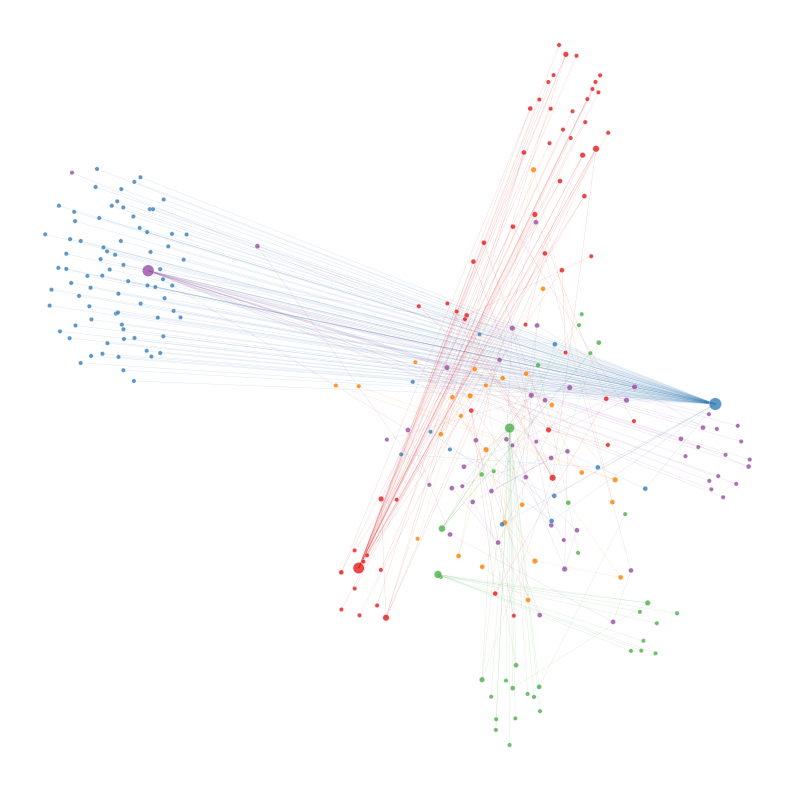

In [10]:
# plotting five largest communities within Time Step 27

import time
from pathlib import Path
import pandas as pd
import networkx as nx
import numpy as np
from scipy.sparse import csr_array
from graspologic.partition import leiden


# g = plot(27)
# nodelist = list(g.nodes)
# adj = nx.to_scipy_sparse_array(g, nodelist=nodelist)

# # the below function simply just converts a graph to be undirected.
# # we can use the networkx function because our graph isn't weighted
# def symmetrze_nx(g):
#     """Leiden requires a symmetric/undirected graph. This converts a directed graph to
#     undirected just for this community detection step"""
#     sym_g = g.to_undirected()
#     return sym_g

# sym_g = symmetrze_nx(g)
# out2 = leiden(sym_g)

# node_df = pd.Series(out2)
# node_df.index.name = "node_id"
# node_df.name = "community"
# node_df = node_df.to_frame()

nodelist = node_df_largest_communities.index
adj = nx.to_scipy_sparse_array(g, nodelist=nodelist)

# node_df["strength"] = adj.sum(axis=1) + adj.sum(axis=0)
# node_df['rank_strength'] = node_df['strength'].rank(method='dense')

from graspologic.embed import LaplacianSpectralEmbed
from graspologic.utils import pass_to_ranks

ptr_adj = pass_to_ranks(adj)

lse = LaplacianSpectralEmbed(n_components=32, concat=True)
lse_embedding = lse.fit_transform(adj)

from umap import UMAP

n_components = 32
n_neighbors = 32
min_dist = 0.8
metric = "cosine"
umap = UMAP(
    n_components=2,
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    metric=metric,
)
umap_embedding = umap.fit_transform(lse_embedding)

node_df_largest_communities["x"] = umap_embedding[:, 0]
node_df_largest_communities["y"] = umap_embedding[:, 1]

def subsample_edges(adjacency, n_edges_kept=100_000):
    row_inds, col_inds = np.nonzero(adjacency)
    n_edges = len(row_inds)
    if n_edges_kept > n_edges:
        return adjacency

    choice_edge_inds = np.random.choice(n_edges, size=n_edges_kept, replace=False)
    row_inds = row_inds[choice_edge_inds]
    col_inds = col_inds[choice_edge_inds]
    data = adjacency[row_inds, col_inds]

    return csr_array((data, (row_inds, col_inds)), shape=adjacency.shape)

from graspologic.plot import networkplot

# this is optional, may not need depending on the number of edges you have
sub_adj = subsample_edges(adj, 100_000)

ax = networkplot(
    sub_adj,
    x="x",
    y="y",
    node_data=node_df_largest_communities,
    node_size="rank_strength",
    node_sizes=(10, 80),
    figsize=(10, 10),
    node_hue="community",
    edge_linewidth=0.3,
)

ax.axis("off")

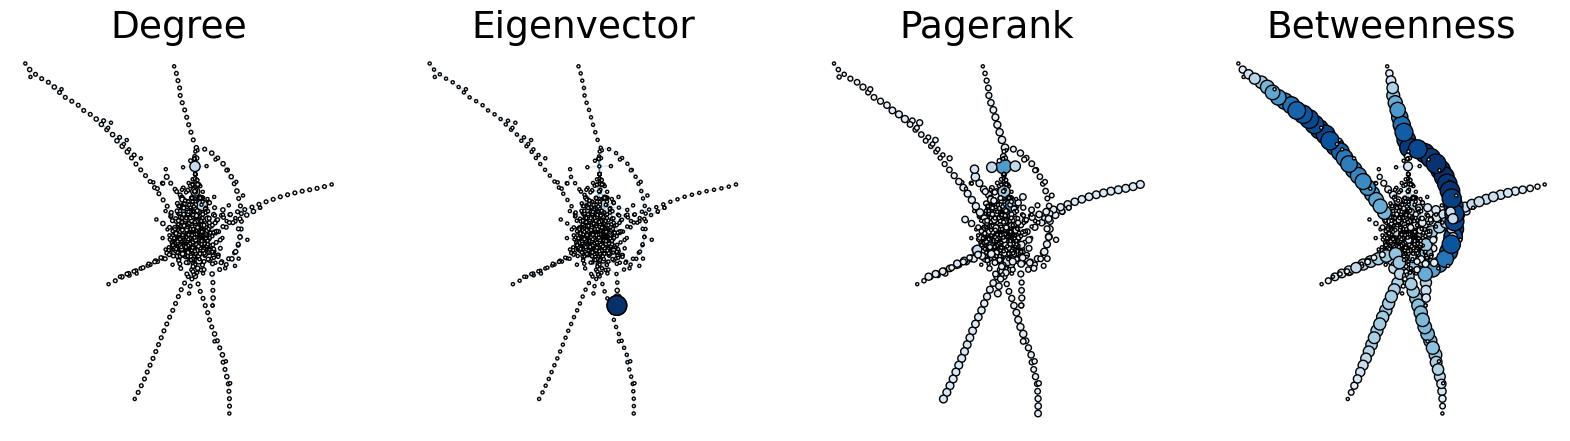

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from graspologic.plot import networkplot
import seaborn as sns
from matplotlib import colors

g = plot(27)

node_data = pd.DataFrame(index=g.nodes())
node_data["degree"] = node_data.index.map(dict(nx.degree(g)))
node_data["eigenvector"] = node_data.index.map(nx.eigenvector_centrality(g, max_iter = 1000))
node_data["pagerank"] = node_data.index.map(nx.pagerank(g))
node_data["betweenness"] = node_data.index.map(nx.betweenness_centrality(g))

pos = nx.kamada_kawai_layout(g)
node_data["x"] = [pos[node][0] for node in node_data.index]
node_data["y"] = [pos[node][1] for node in node_data.index]

sns.set_context("talk", font_scale=1.5)
fig, axs = plt.subplots(1, 4, figsize=(20, 5))


def plot_node_scaled_network(A, node_data, key, ax):
    # REF: https://github.com/mwaskom/seaborn/blob/9425588d3498755abd93960df4ab05ec1a8de3ef/seaborn/_core.py#L215

    levels = list(np.sort(node_data[key].unique()))
    cmap = sns.color_palette("Blues", as_cmap=True)
    vmin = np.min(levels)
    norm = colors.Normalize(vmin=0.3 * vmin)
    palette = dict(zip(levels, cmap(norm(levels))))

    networkplot(
        A,
        node_data=node_data,
        x="x",
        y="y",
        ax=ax,
        edge_linewidth=1.0,
        node_size=key,
        node_hue=key,
        palette=palette,
        node_sizes=(5, 200),
        node_kws=dict(linewidth=1, edgecolor="black"),
        node_alpha=1.0,
        edge_kws=dict(color=sns.color_palette()[0]),
    )

    ax.axis("off")
    ax.set_title(key.capitalize())


ax = axs[0]
plot_node_scaled_network(A, node_data, "degree", ax)

ax = axs[1]
plot_node_scaled_network(A, node_data, "eigenvector", ax)

ax = axs[2]
plot_node_scaled_network(A, node_data, "pagerank", ax)

ax = axs[3]
plot_node_scaled_network(A, node_data, "betweenness", ax)

fig.set_facecolor("w")

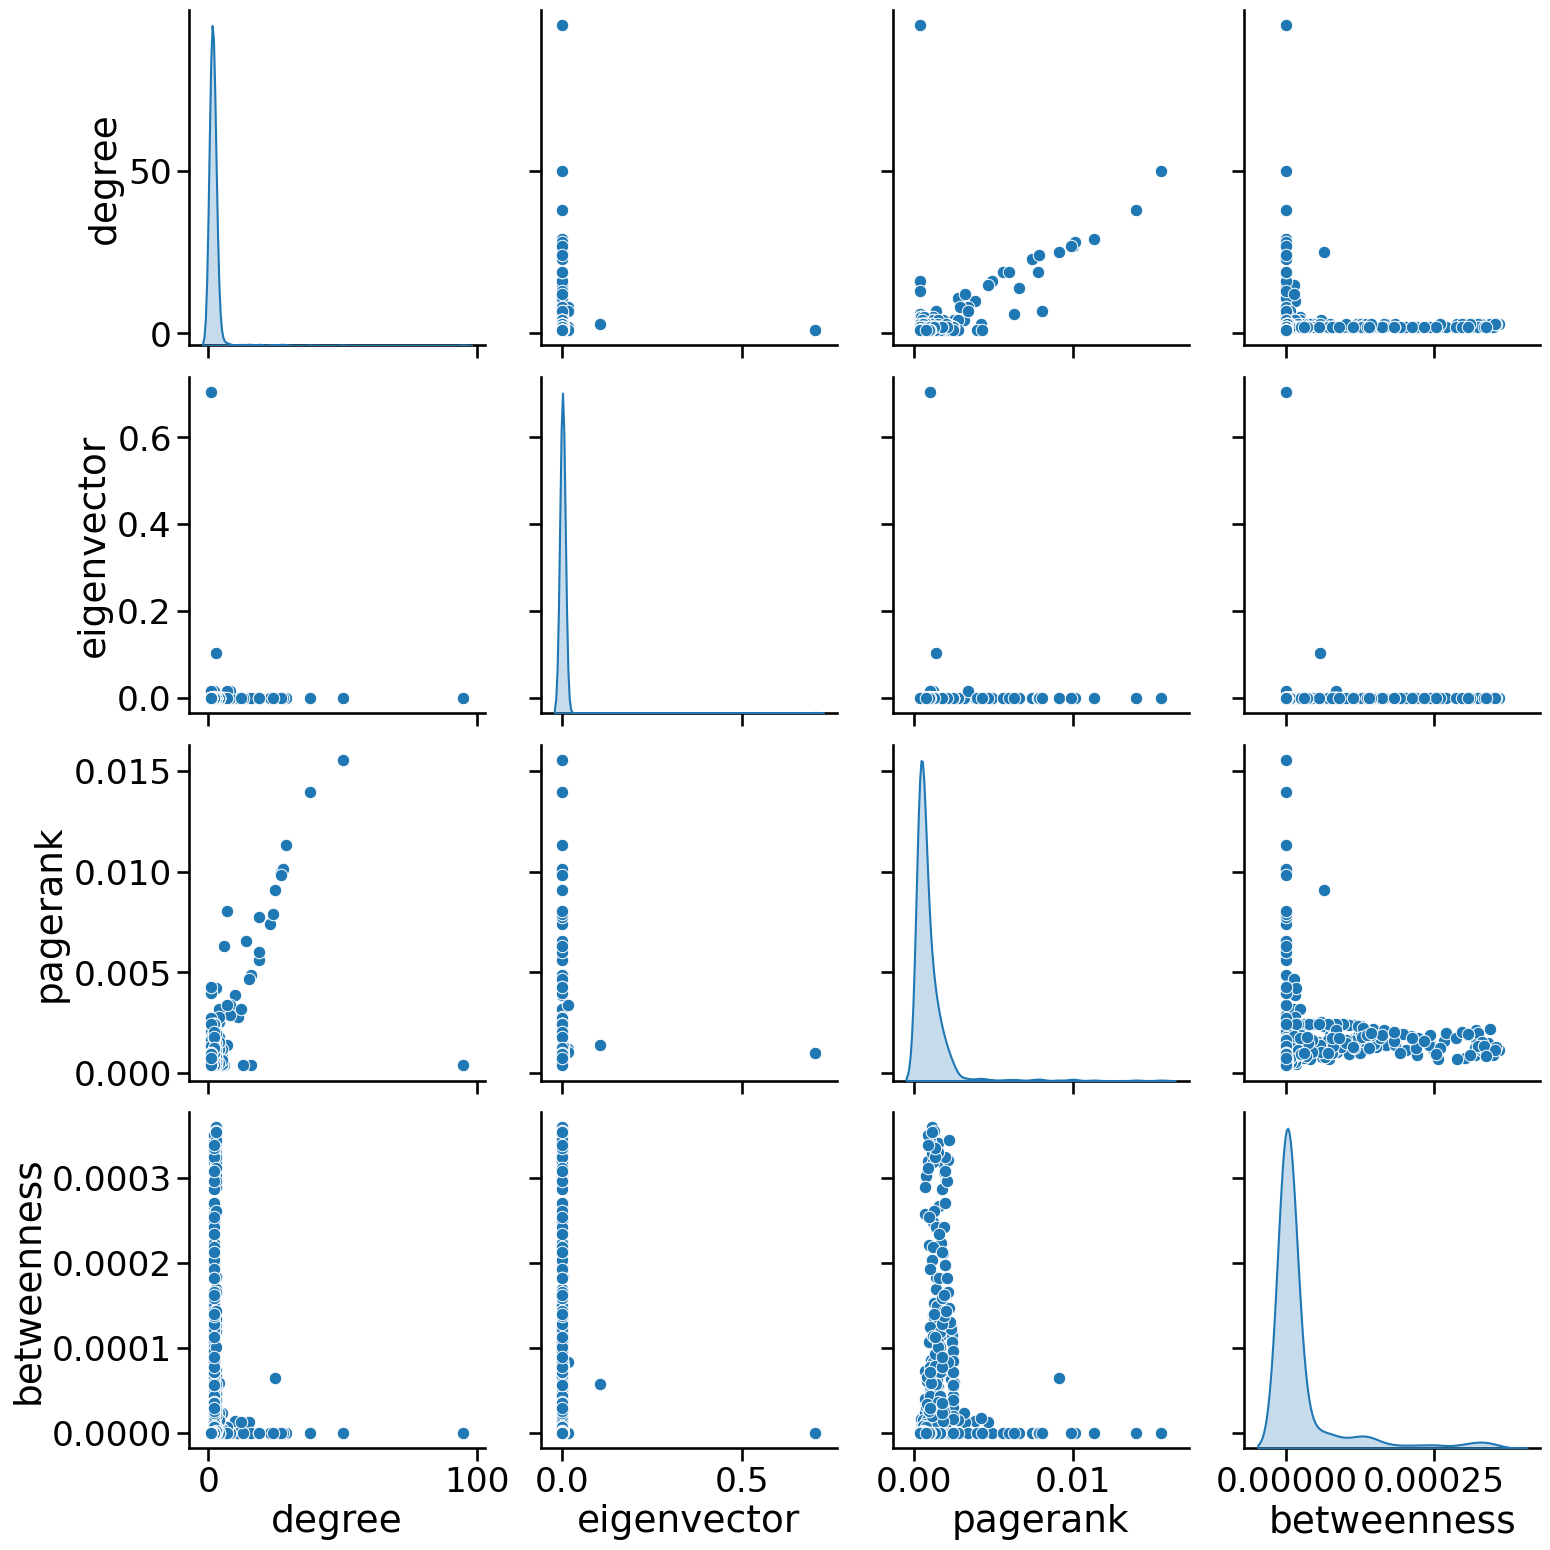

In [28]:
sns.pairplot(
    node_data, vars=["degree", "eigenvector", "pagerank", "betweenness"], diag_kind="kde", height=4
)

Here we try some community detection, in this case we're attempting to divide the network into two communities. This is mostly just to test the algorithims and learn the techniques, as the network we have isnt't made to be split communities. 

First, we'll start with Naive Optimization

In [29]:
import networkx as nx
import pandas as pd

g = plot(27)

nodelist = list(g.nodes)
node_df = pd.DataFrame(index=nodelist)

pos = nx.kamada_kawai_layout(g)

xs = []
ys = []
for node in nodelist:
    xs.append(pos[node][0])
    ys.append(pos[node][1])
xs = np.array(xs)
ys = np.array(ys)

node_df["x"] = xs
node_df["y"] = ys

adj = nx.to_numpy_array(g, nodelist=nodelist)
n = adj.shape[0]

node_df["degree"] = adj.sum(axis=0)


In [30]:
# random bernoullis
rng = np.random.default_rng(888)
partition = rng.binomial(1, 0.5, size=n)

partition

array([0, 0, 0, ..., 0, 0, 1])

In [31]:
def modularity_from_adjacency(sym_adj, partition, resolution=1):
    if isinstance(partition, dict):
        partition_labels = np.vectorize(partition.__getitem__)(
            np.arange(sym_adj.shape[0])
        )
    else:
        partition_labels = partition
    partition_labels = np.array(partition_labels)
    in_comm_mask = partition_labels[:, None] == partition_labels[None, :]
    degrees = np.squeeze(np.asarray(sym_adj.sum(axis=0)))
    degree_prod_mat = np.outer(degrees, degrees) / sym_adj.sum()
    mod_mat = sym_adj - resolution * degree_prod_mat
    return mod_mat[in_comm_mask].sum() / sym_adj.sum()


mod_score = modularity_from_adjacency(adj, partition)
mod_score



-0.014742446988177846

(<Figure size 1500x700 with 4 Axes>,
 <AxesSubplot: title={'center': 'Betweenness'}>)

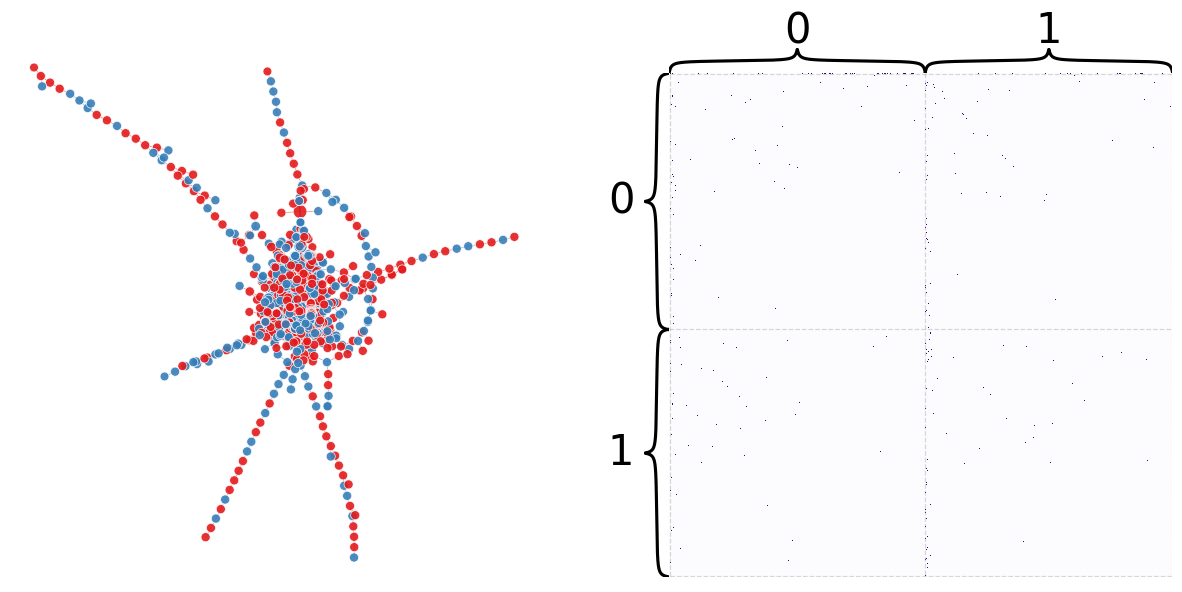

In [32]:
from graspologic.plot import networkplot, heatmap

node_df["random_partition"] = partition


def plot_network_partition(adj, node_data, partition_key):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))

    networkplot(
        adj,
        x="x",
        y="y",
        node_data=node_df.reset_index(),
        node_alpha=0.9,
        edge_alpha=0.7,
        edge_linewidth=0.4,
        node_hue=partition_key,
        node_size="degree",
        edge_hue="source",
        ax=axs[0],
    )
    _ = axs[0].axis("off")

    _ = heatmap(
        adj,
        inner_hier_labels=node_data[partition_key],
        ax=axs[1],
        cbar=False,
        cmap="Purples",
        vmin=0,
        center=None,
        sort_nodes=True,
    )

    return fig, ax


plot_network_partition(adj, node_df, "random_partition")

In [36]:
n_trials = 10000

best_scores = []
best_iterations = []
last_mod_score = mod_score
for iteration in range(n_trials):
    # choose a random node to perturb
    index = rng.choice(n)

    # check what group it is currently in, and swap it
    current_group = partition[index]
    if current_group:
        partition[index] = 0
    else:
        partition[index] = 1

    # compute modularity with this slightly modified partition
    mod_score = modularity_from_adjacency(adj, partition)

    # decide whether to keep that change or not
    if mod_score < last_mod_score:
        # swap it back
        if current_group:
            partition[index] = 1
        else:
            partition[index] = 0
    else:
        last_mod_score = mod_score
        best_scores.append(mod_score)
        best_iterations.append(iteration)

mod_score

# took 77 seconds!

0.401541095890411

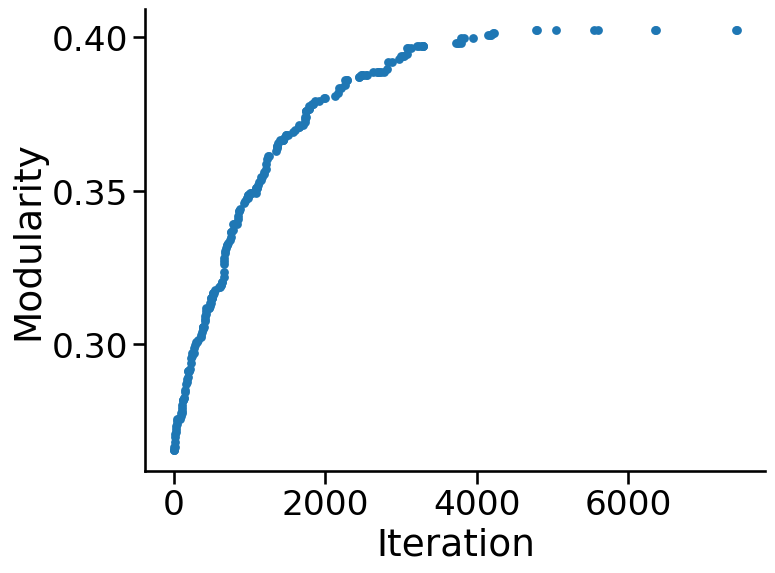

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.scatterplot(x=best_iterations, y=best_scores, ax=ax, s=40, linewidth=0)
ax.set(ylabel="Modularity", xlabel="Iteration")
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

(<Figure size 1500x700 with 4 Axes>,
 <AxesSubplot: xlabel='Iteration', ylabel='Modularity'>)

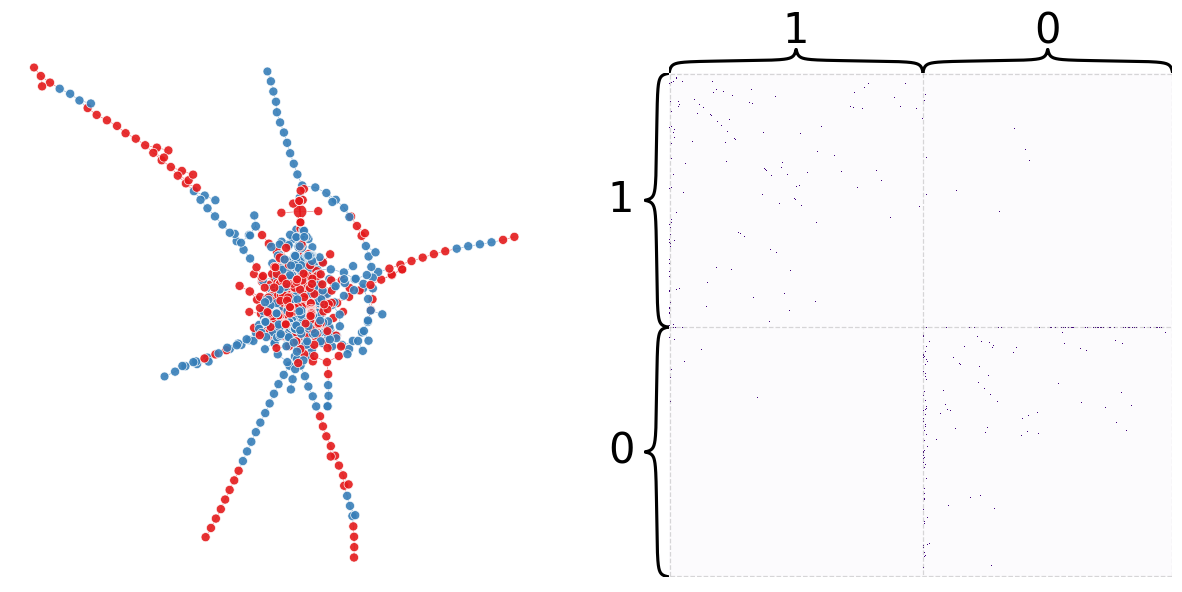

In [40]:
node_df["naive_partition"] = partition

plot_network_partition(adj, node_df, "naive_partition")

Both spectral and leidan optimization require the network to be undirected. The following code will convert the directed network into being undirected. 

In [49]:
def symmetrze_nx(g):
    sym_g = g.to_undirected()
    return sym_g


Spectral optimization:

In [50]:
g = symmetrze_nx(g)
B = nx.modularity_matrix(g, nodelist=nodelist)
eigenvalues, eigenvectors = np.linalg.eigh(B)
first_eigenvector = np.squeeze(np.asarray(eigenvectors[:, -1]))
eig_partition = first_eigenvector.copy()
eig_partition[eig_partition > 0] = 1
eig_partition[eig_partition <= 0] = 0
eig_partition = eig_partition.astype(int)
modularity_from_adjacency(adj, eig_partition)

<class 'networkx.utils.decorators.argmap'> compilation 25:5: FutureWarning: modularity_matrix will return a numpy array instead of a matrix in NetworkX 3.0.
  import itertools


0.24689053996997573

(<Figure size 1500x700 with 4 Axes>,
 <AxesSubplot: xlabel='Iteration', ylabel='Modularity'>)

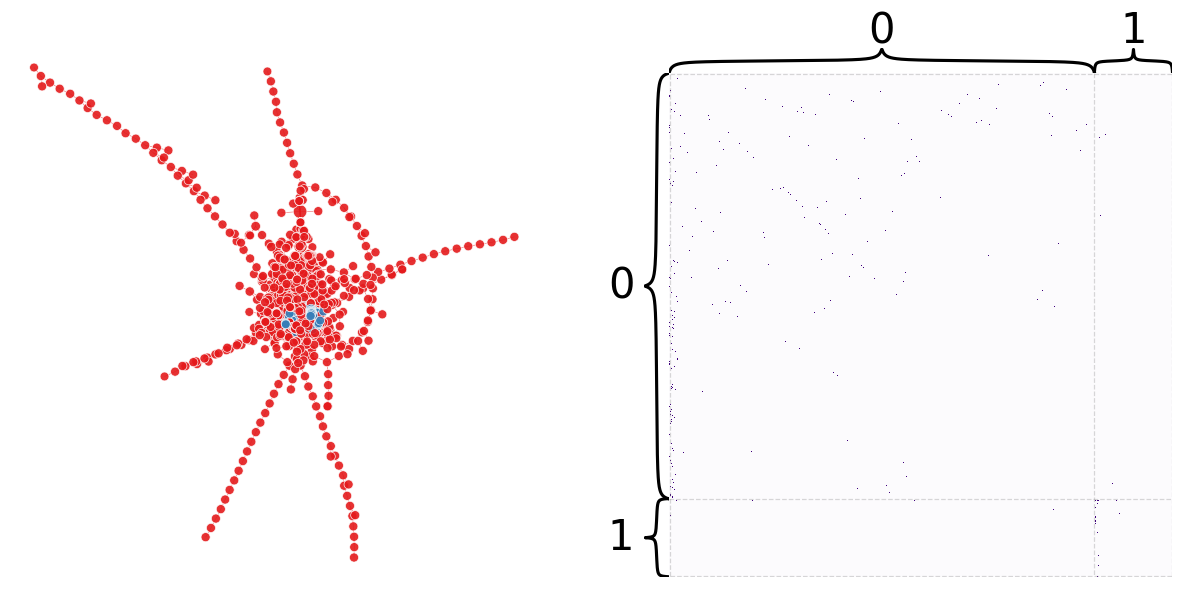

In [51]:
node_df["eig_partition"] = eig_partition

plot_network_partition(adj, node_df, "eig_partition")

That was pretty bad... let's try leiden!

In [52]:
from graspologic.partition import leiden, modularity

leiden_partition_map = leiden(g, random_seed=7)
nx.set_edge_attributes(g, 1, "weight")

modularity(g, leiden_partition_map)


0.9048667960686809

(<Figure size 1500x700 with 4 Axes>,
 <AxesSubplot: xlabel='Iteration', ylabel='Modularity'>)

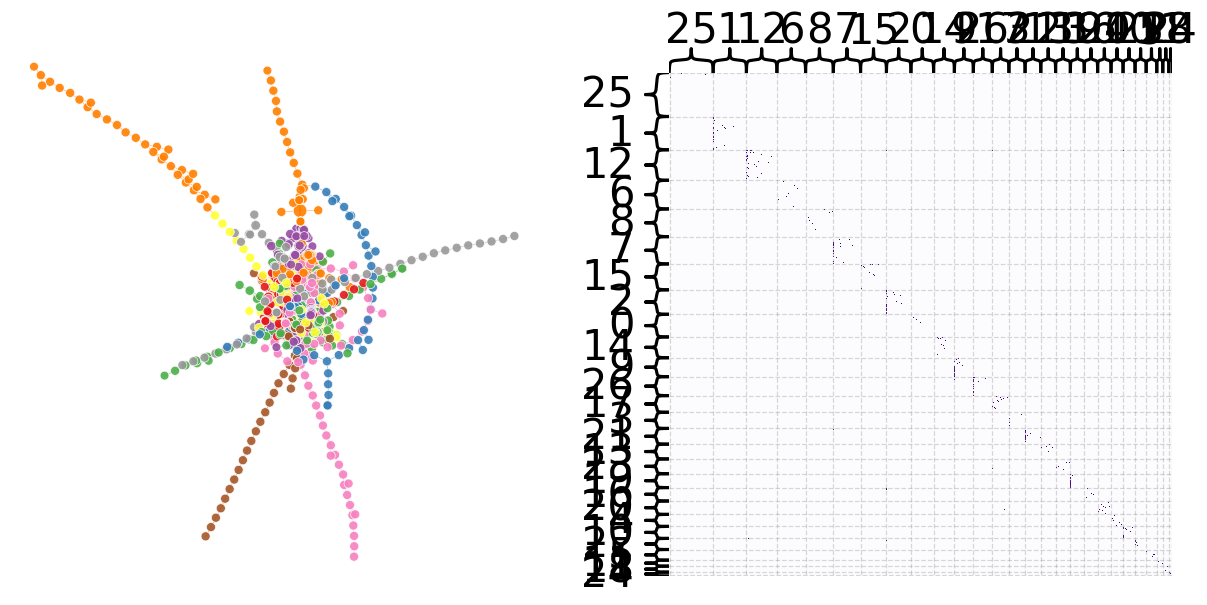

In [53]:
node_df["leiden_partition"] = node_df.index.map(leiden_partition_map)

plot_network_partition(adj, node_df, "leiden_partition")


In [92]:
g = plot(27)
in_degree = list(g.in_degree())
df_in_degree = pd.DataFrame(in_degree, columns =['id', 'in degree'])
out_degree = list(g.out_degree())
df_out_degree = pd.DataFrame(out_degree, columns =['id', 'out degree'])
df_in_out_degree = pd.merge(df_in_degree, df_out_degree, how="inner", on="id")
df_in_out_degree_1_1 = df_in_out_degree.loc[(df_in_out_degree['in degree'] == 1) & (df_in_out_degree['out degree'] == 1)]
print(df_in_out_degree_1_1.shape)
print(df_in_out_degree.shape)

(348, 3)
(1089, 3)


348 of the 1089 nodes (32%) have an in degree and an out degree of 1. If we look at the graph above, we can see there are chains of nodes. It seems that occasionally, there are transactions that pass through a chain of entities. These entities simply receieve the transaction from one entity and transfer it to the next. We can reason that this could potentially be a part of a money laundering operation, specifically layering. In this step, money is transfered through multiple accounts to further the distance from the money from the original source. These entities are likely shell companies, trusts, or other corporate vehicles which aren't required to reveal their true owner.